In [2]:
import pandas as pd

df = pd.read_csv("data/data2019.csv")

In [3]:
start_date = "2019-02-01"
end_date = "2019-02-31"
df = df[(df["date"] >= start_date) & (df["date"] <= end_date)]

In [4]:
df["date"] = df["date"].apply(lambda x: x[:-6])
df["date"] = pd.to_datetime(df["date"])
df["dayOfWeek"] = df["date"].dt.dayofweek
df["month"] = df["date"].dt.month
df["id"] = 1

In [5]:
WEEKEND_INDICES = [5, 6]
df["weekend"] = df["dayOfWeek"].apply(lambda x: 1 if x in WEEKEND_INDICES else 0)

In [6]:
import holidays
timestamps = df["date"]
country_holidays = holidays.country_holidays(
    country="TR",
    years=range(timestamps.min().year, timestamps.max().year + 1),
)

pd.Series(country_holidays).sort_index().head()

df['holiday'] = df['date'].apply(lambda x: 1 if x in country_holidays else 0)

In [7]:
df["idmUsd"] = df["idm"] / df["exchangeRate"]
df["smpUsd"] = df["smp"] / df["exchangeRate"]

In [8]:
df = df.drop(
    columns=[
        "smp",
        "mcp",
        "upRegulationZeroCoded",
        "downRegulationZeroCoded",
        "upRegulationDelivered",
        "downRegulationDelivered",
        "ImbalanceToVolumeRatio",
        "exchangeRate",
    ]
)

In [9]:
df.rename({"netImbalanceVolume": "target"}, axis=1, inplace=True)
df['direction'] = df['target'].apply(lambda x: 1 if x > 0 else -1)
df['netImbalanceVolume'] = df['target']

In [10]:
from autogluon.timeseries import TimeSeriesDataFrame

data = TimeSeriesDataFrame(
    df,
    id_column="id",
    timestamp_column="date",
)

/opt/anaconda3/envs/bitirme/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
prediction_length = 24
train_data, test_data = data.train_test_split(prediction_length)

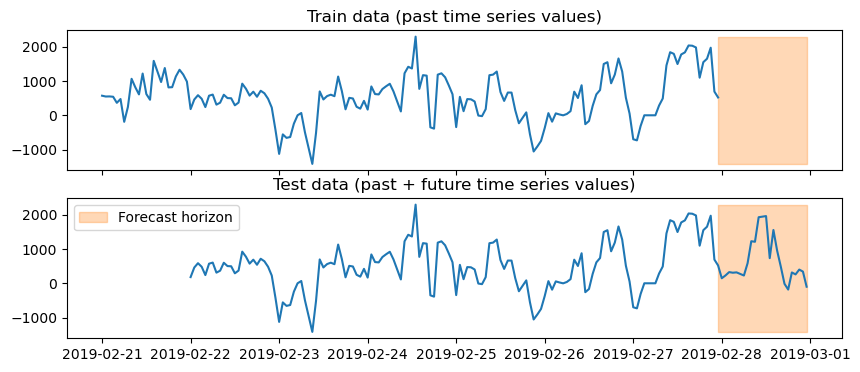

In [46]:
import matplotlib.pyplot as plt
import numpy as np

item_id = 1
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=[10, 4], sharex=True)
train_ts = train_data[-24*7:].loc[item_id]['netImbalanceVolume']
test_ts = test_data[-24*7:].loc[item_id]['netImbalanceVolume']
ax1.set_title("Train data (past time series values)")
ax1.plot(train_ts)
ax2.set_title("Test data (past + future time series values)")
ax2.plot(test_ts)
for ax in (ax1, ax2):
    ax.fill_between(np.array([train_ts.index[-1], test_ts.index[-1]]), test_ts.min(), test_ts.max(), color="C1", alpha=0.3, label="Forecast horizon")
plt.legend()
plt.show()

In [1161]:
from autogluon.timeseries import TimeSeriesPredictor

predictor = TimeSeriesPredictor(
    path="./volume_forecast/february_monthly_forecast_val_windows_7_high_quality",
    prediction_length=24,
    target="target",
    known_covariates_names=[
        "hour",
        "mcpUsd",
        "damVolume",
        "weekend",
        "holiday",
        "dayOfWeek",
    ],
    eval_metric="MSE",
)

predictor.fit(train_data, presets="high_quality", num_val_windows=7)

Beginning AutoGluon training...
AutoGluon will save models to './volume_forecast/february_monthly_forecast_val_windows_7_high_quality'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.13
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.1.0: Mon Oct  9 21:28:31 PDT 2023; root:xnu-10002.41.9~6/RELEASE_ARM64_T8112
CPU Count:          8
GPU Count:          0
Memory Avail:       5.35 GB / 16.00 GB (33.4%)
Disk Space Avail:   95.68 GB / 460.43 GB (20.8%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MSE,
 'hyperparameters': 'default',
 'known_covariates_names': ['hour',
                            'mcpUsd',
                            'damVolume',
                            'weekend',
                            'holiday',
                            'dayOfWeek'],
 'num_val_windows': 7,
 'prediction_length': 24,
 'quantile_levels': [0.1

In [44]:
from autogluon.timeseries import TimeSeriesPredictor
predictor = TimeSeriesPredictor.load("./volume_forecast/february_monthly_forecast_val_windows_7_high_quality")

In [45]:
leaderboard = predictor.leaderboard(display=True)

                        model      score_val  pred_time_val  fit_time_marginal  fit_order
0            WeightedEnsemble -345181.879589       0.164383           3.328584         11
1   TemporalFusionTransformer -411739.396850       0.018126        1445.696852          8
2                    PatchTST -412449.521863       0.007496         449.477967         10
3                   AutoARIMA -439976.869524      34.642403         210.122971          7
4                      DeepAR -453305.317322       0.123158         450.456843          9
5               DirectTabular -482055.707352       0.023907           8.100685          2
6                        NPTS -519334.890442       0.050504           0.274985          4
7                  CrostonSBA -542070.814029       0.015289           4.679106          3
8               SeasonalNaive -741708.661431       0.015603           1.105505          1
9                     AutoETS -836511.005365       0.140528           6.929733          6
10      Dy

In [15]:
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe

future_index = get_forecast_horizon_index_ts_dataframe(train_data, prediction_length=24)
future_timestamps = future_index.get_level_values("timestamp")

In [16]:
known_covariates = pd.DataFrame(index=future_index)
known_covariates["weekend"] = future_timestamps.weekday.isin(WEEKEND_INDICES).astype(
    float
)
known_covariates["holiday"] = future_timestamps.isin(country_holidays).astype(float)
known_covariates["dayOfWeek"] = future_timestamps.day
known_covariates["hour"] = future_timestamps.hour
known_covariates["date"] = future_timestamps

/var/folders/97/rdjnvwl17_59d789kk3r0__r0000gn/T/ipykernel_29140/502973405.py:5: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  known_covariates["holiday"] = future_timestamps.isin(country_holidays).astype(float)


In [17]:
for date in future_timestamps:
    known_covariates.loc[known_covariates["date"] == date, "mcpUsd"] = df.loc[
        df["date"] == date, "mcpUsd"
    ].values[0]
    known_covariates.loc[known_covariates["date"] == date, "damVolume"] = df.loc[
        df["date"] == date, "damVolume"
    ].values[0]


known_covariates.drop("date", axis=1, inplace=True)

In [18]:
predictions = predictor.predict(train_data, known_covariates=known_covariates)

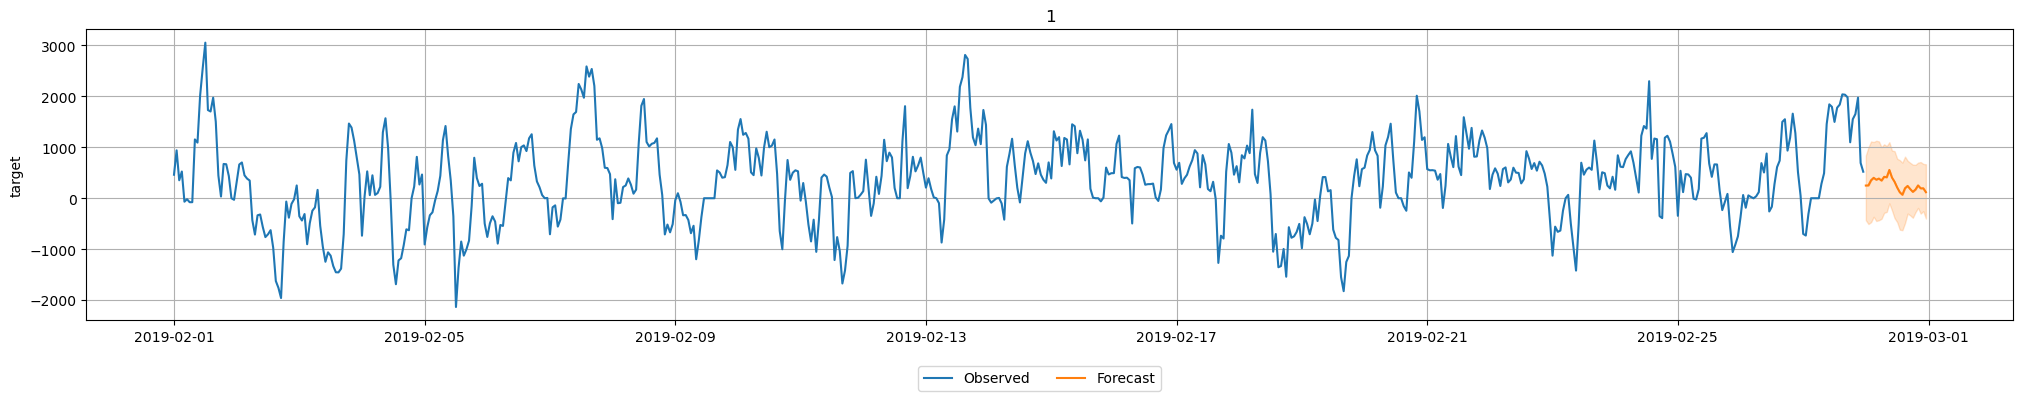

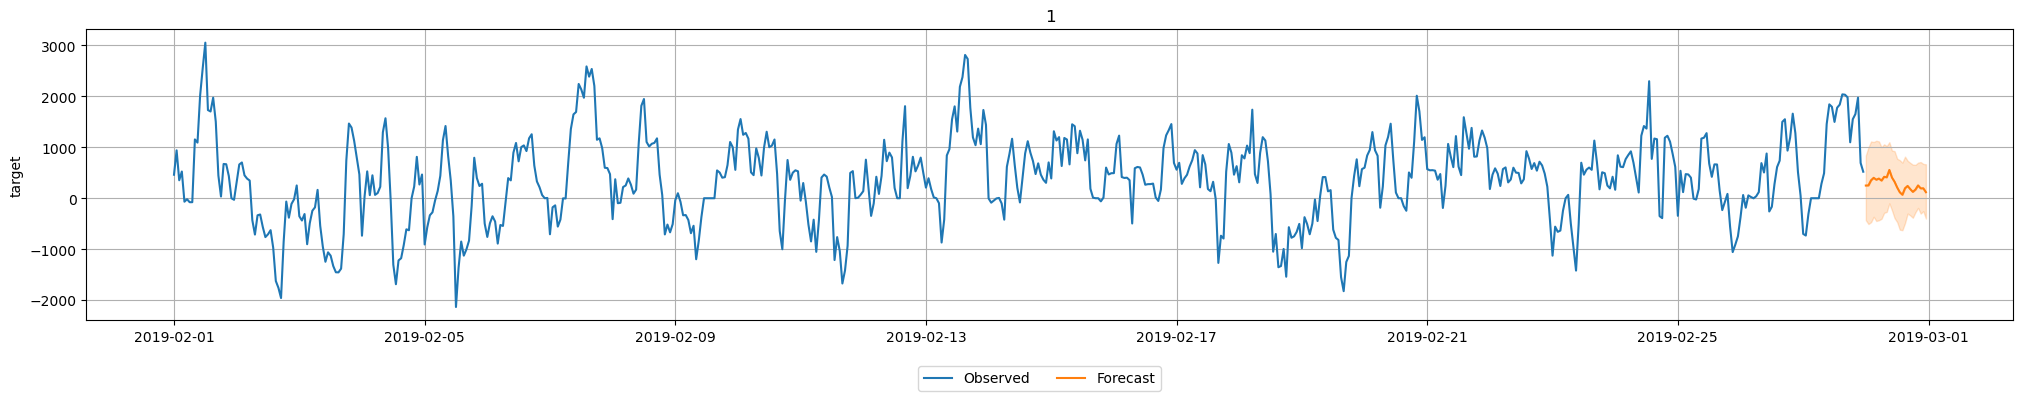

In [19]:
predictor.plot(train_data, predictions=predictions)

In [20]:
comparison = zip(predictions['mean'].values, test_data['target'][-24:].values)

In [21]:
comparison = pd.DataFrame(list(comparison), columns=["predicted", "actual"])

In [22]:
comparison["direction_forecast"] = ["up" if x > 0 else "down" for x in comparison["predicted"]]
comparison["direction_actual"] = ["up" if x > 0 else "down" for x in comparison["actual"]]
comparison["correct"] = comparison["direction_forecast"] == comparison["direction_actual"]
comparison

,predicted,actual,direction_forecast,direction_actual,correct
0,248.486411,147.39,up,up,True
1,267.909858,228.42,up,up,True
2,350.607780,326.50,up,up,True
3,392.775738,308.71,up,up,True
4,366.097549,318.97,up,up,True
5,381.240832,272.10,up,up,True
6,339.774667,227.25,up,up,True
7,425.510838,587.33,up,up,True
8,419.789855,1228.96,up,up,True
9,554.254386,1212.60,up,up,True


<Axes: title={'center': 'Predicted vs Actual'}>

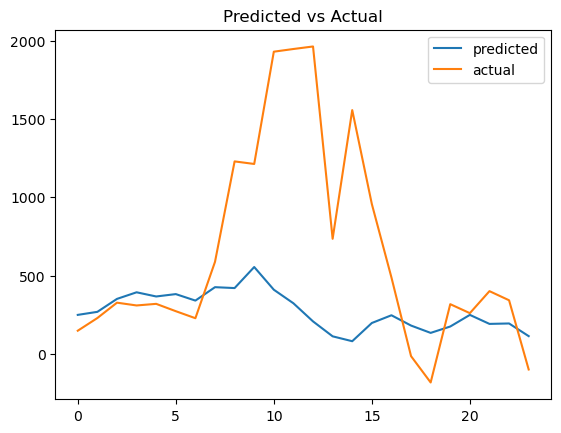

In [23]:
comparison.plot(y=["predicted", "actual"], title="Predicted vs Actual")

In [24]:
predictor.evaluate(test_data)

{'MSE': -473249.1130255845}

In [25]:
trade_data = pd.DataFrame()
trade_data['netImbalanceVolume'] = comparison['predicted']
trade_data['date'] = future_timestamps

# ["mcpUsd", "netImbalanceVolume", "idmUsd", "hour", "dayOfWeek"]
for date in future_timestamps:
    trade_data.loc[trade_data["date"] == date, "mcpUsd"] = df.loc[
        df["date"] == date, "mcpUsd"
    ].values[0]
    trade_data.loc[trade_data["date"] == date, "damVolume"] = df.loc[
        df["date"] == date, "damVolume"
    ].values[0]
    trade_data.loc[trade_data["date"] == date, "idmUsd"] = df.loc[
        df["date"] == date, "idmUsd"
    ].values[0]
    trade_data.loc[trade_data["date"] == date, "smpUsd"] = df.loc[
        df["date"] == date, "smpUsd"
    ].values[0]

trade_data['hour'] = future_timestamps.hour
trade_data['dayOfWeek'] = future_timestamps.dayofweek
trade_data.reset_index(drop=True, inplace=True)

In [26]:
trade_data = pd.get_dummies(trade_data, columns=["hour"], drop_first=True)

In [27]:
for i in range(1, 7):
    trade_data[f"dayOfWeek_{i}"] = trade_data["dayOfWeek"].apply(lambda x: True if x == i else False)

trade_data.drop("dayOfWeek", axis=1, inplace=True)

In [28]:
from autogluon.tabular import TabularPredictor
trade_predictor = TabularPredictor.load("AutogluonModels/HourAndDayMediumUsd")

In [29]:
trade_predictions = trade_predictor.predict(trade_data)
trade_predictions_proba = trade_predictor.predict_proba(trade_data)

/opt/anaconda3/envs/bitirme/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [30]:
trade_data_accurate_volume = trade_data.copy()
trade_data_accurate_volume["netImbalanceVolume"] = comparison["actual"]

trade_predictions_accurate_volume = trade_predictor.predict(trade_data_accurate_volume)
trade_predictions_proba_accrate_volume = trade_predictor.predict_proba(trade_data_accurate_volume)

In [31]:
# Only get probabilities for the class 1
trade_comparison = list(zip(trade_predictions.values, trade_predictions_proba.iloc[:, 1].values, trade_predictions_accurate_volume.values, trade_predictions_proba_accrate_volume.iloc[:, 1].values))
trade_comparison = pd.DataFrame(trade_comparison, columns=["tradeSuggestionWithoutVolume", "longOpportunityProbaWithoutVolume", "tradeSuggestionWithVolume", "longOpportunityProbaWithVolume"])

In [32]:
trade_comparison["netImbalanceVolumeActual"] = comparison["actual"]
trade_comparison["netImbalanceVolumePredicted"] = comparison["predicted"]
trade_comparison["mcpUsd"] = trade_data["mcpUsd"]
trade_comparison["idmUsd"] = trade_data["idmUsd"]
trade_comparison["damVolume"] = trade_data["damVolume"]
trade_comparison["smpUsd"] = trade_data["smpUsd"]
trade_comparison["date"] = trade_data["date"]

In [33]:
NEGATIVE_IMBALANCE_PENALTY = 1.03
POSITIVE_IMBALANCE_PENALTY = 0.97


def calculate_negative_imbalance_price(smp, mcp):
    return max(smp, mcp) * NEGATIVE_IMBALANCE_PENALTY


def calculate_positive_imbalance_price(smp, mcp):
    return min(smp, mcp) * POSITIVE_IMBALANCE_PENALTY

In [34]:
trade_comparison["positive_imbalance_price"] = trade_comparison.apply(
    lambda row: calculate_positive_imbalance_price(row["smpUsd"], row["mcpUsd"]), axis=1
)
trade_comparison["negative_imbalance_price"] = trade_comparison.apply(
    lambda row: calculate_negative_imbalance_price(row["smpUsd"], row["mcpUsd"]), axis=1
)

In [35]:
def calculate_shortselling_profit(idm, negative_imbalance_price):
    return max(idm - negative_imbalance_price, 0)


def calculate_long_profit(idm, positive_imbalance_price):
    return max(positive_imbalance_price - idm, 0)


def calculate_shortselling_loss(idm, negative_imbalance_price):
    return max(negative_imbalance_price - idm, 0)


def calculate_long_loss(idm, positive_imbalance_price):
    return max(idm - positive_imbalance_price, 0)

In [36]:
trade_comparison["shortselling_profit"] = trade_comparison.apply(
    lambda row: calculate_shortselling_profit(
        row["idmUsd"], row["negative_imbalance_price"]
    ),
    axis=1,
)
trade_comparison["long_profit"] = trade_comparison.apply(
    lambda row: calculate_long_profit(row["idmUsd"], row["positive_imbalance_price"]),
    axis=1,
)

trade_comparison["total_profit"] = trade_comparison["shortselling_profit"] + trade_comparison["long_profit"]

trade_comparison["shortselling_loss"] = trade_comparison.apply(
    lambda row: calculate_shortselling_loss(
        row["idmUsd"], row["negative_imbalance_price"]
    ),
    axis=1,
)

trade_comparison["long_loss"] = trade_comparison.apply(
    lambda row: calculate_long_loss(row["idmUsd"], row["positive_imbalance_price"]),
    axis=1,
)

trade_comparison["total_loss"] = trade_comparison["shortselling_loss"] + trade_comparison["long_loss"]
trade_comparison['is_shortselling_profitable'] = trade_comparison['shortselling_profit'] > 0
trade_comparison['is_long_profitable'] = trade_comparison['long_profit'] > 0

In [37]:
correct_predictions_without_volume = trade_comparison[trade_comparison["tradeSuggestionWithoutVolume"] == trade_comparison["is_long_profitable"]]
correct_predictions_with_volume = trade_comparison[trade_comparison["tradeSuggestionWithVolume"] == trade_comparison["is_long_profitable"]]
print(f"Correct predictions without volume: {len(correct_predictions_without_volume)}")
print(f"Correct predictions with volume: {len(correct_predictions_with_volume)}")

Correct predictions without volume: 23
Correct predictions with volume: 24


In [38]:
false_predictions_without_volume = trade_comparison[trade_comparison["tradeSuggestionWithoutVolume"] != trade_comparison["is_long_profitable"]]
false_predictions_with_volume = trade_comparison[trade_comparison["tradeSuggestionWithVolume"] != trade_comparison["is_long_profitable"]]
print(f"False predictions without volume: {len(false_predictions_without_volume)}")
print(f"False predictions with volume: {len(false_predictions_with_volume)}")

False predictions without volume: 1
False predictions with volume: 0


In [39]:
trade_comparison.loc[:, ["tradeSuggestionWithoutVolume", "longOpportunityProbaWithoutVolume", "tradeSuggestionWithVolume", "longOpportunityProbaWithVolume", "is_long_profitable"]]

,tradeSuggestionWithoutVolume,longOpportunityProbaWithoutVolume,tradeSuggestionWithVolume,longOpportunityProbaWithVolume,is_long_profitable
0,False,0.023568,False,0.026793,False
1,False,0.029669,False,0.028666,False
2,False,0.120694,False,0.112756,False
3,True,0.990949,True,0.988778,True
4,True,0.951371,True,0.938398,True
5,True,0.992496,True,0.992228,True
6,True,0.992773,True,0.992015,True
7,True,0.996170,True,0.996335,True
8,True,0.995656,True,0.996030,True
9,True,0.995989,True,0.996116,True


In [40]:
POSITIVE_IMBALANCE_PENALTY = 0.97
NEGATIVE_IMBALANCE_PENALTY = 1.03
def calculate_pnl(mcp, smp, idm, strategy):
    positive_imbalance_price = min(mcp, smp) * POSITIVE_IMBALANCE_PENALTY
    negative_imbalance_price = max(mcp, smp) * NEGATIVE_IMBALANCE_PENALTY
    if strategy == 'buy':
        return positive_imbalance_price - idm
    elif strategy == 'sell':
        return idm - negative_imbalance_price
    else:
        return 0


In [41]:
trade_comparison["tradeSuggestionWithoutVolume"] = trade_comparison["tradeSuggestionWithoutVolume"].apply(lambda x: 'buy' if x == 1  else 'hold')
trade_comparison["tradeSuggestionWithVolume"] = trade_comparison["tradeSuggestionWithVolume"].apply(lambda x: 'buy' if x == 1  else 'hold')

trade_comparison["pnlWithoutVolume"] = trade_comparison.apply(
    lambda row: calculate_pnl(row["mcpUsd"], row["smpUsd"], row["idmUsd"], row["tradeSuggestionWithoutVolume"]),
    axis=1,
)

trade_comparison["pnlWithVolume"] = trade_comparison.apply(
    lambda row: calculate_pnl(row["mcpUsd"], row["smpUsd"], row["idmUsd"], row["tradeSuggestionWithVolume"]),
    axis=1,
)

trade_comparison["pnlWithoutVolume"].sum(), trade_comparison["pnlWithVolume"].sum()

(30.957053866685914, 32.01854235597523)

,tradeSuggestionWithoutVolume,longOpportunityProbaWithoutVolume,tradeSuggestionWithVolume,longOpportunityProbaWithVolume,netImbalanceVolumeActual,netImbalanceVolumePredicted,mcpUsd,idmUsd,damVolume,smpUsd,...,shortselling_profit,long_profit,total_profit,shortselling_loss,long_loss,total_loss,is_shortselling_profitable,is_long_profitable,pnlWithoutVolume,pnlWithVolume
0,hold,0.023568,hold,0.026793,147.39,248.486411,5.66,7.058486,14504.1,10.700967,...,0,0.000000,0.000000,3.963510,1.568286,5.531796,False,False,0.000000,0.000000
1,hold,0.029669,hold,0.028666,228.42,267.909858,37.38,36.922995,14560.6,37.380000,...,0,0.000000,0.000000,1.578405,0.664395,2.242800,False,False,0.000000,0.000000
2,hold,0.120694,hold,0.112756,326.50,350.607780,50.99,49.558450,14350.4,54.372462,...,0,0.000000,0.000000,6.445186,0.098150,6.543336,False,False,0.000000,0.000000
3,buy,0.990949,buy,0.988778,308.71,392.775738,50.69,48.119808,14028.4,50.690000,...,0,1.049492,1.049492,4.090892,0.000000,4.090892,False,True,1.049492,1.049492
4,buy,0.951371,buy,0.938398,318.97,366.097549,30.22,28.510681,13873.0,35.886250,...,0,0.802719,0.802719,8.452156,0.000000,8.452156,False,True,0.802719,0.802719
5,buy,0.992496,buy,0.992228,272.10,381.240832,50.85,45.664346,14079.6,50.850000,...,0,3.660154,3.660154,6.711154,0.000000,6.711154,False,True,3.660154,3.660154
6,buy,0.992773,buy,0.992015,227.25,339.774667,52.46,46.766037,15317.1,52.460000,...,0,4.120163,4.120163,7.267763,0.000000,7.267763,False,True,4.120163,4.120163
7,buy,0.996170,buy,0.996335,587.33,425.510838,56.75,50.223061,17626.1,57.601750,...,0,4.824439,4.824439,9.106742,0.000000,9.106742,False,True,4.824439,4.824439
8,buy,0.995656,buy,0.996030,1228.96,419.789855,61.02,54.656785,19837.9,65.728666,...,0,4.532615,4.532615,13.043740,0.000000,13.043740,False,True,4.532615,4.532615
9,buy,0.995989,buy,0.996116,1212.60,554.254386,61.10,54.764137,20542.2,65.802324,...,0,4.502863,4.502863,13.012257,0.000000,13.012257,False,True,4.502863,4.502863


In [43]:
trade_comparison.to_csv("data/trade_comparison.csv", index=False)